## KNN

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import gc


In [2]:
# If importing is giving you an issue, don't import mixed data type columns 
#good_import_cols1 = pd.Series(range(0,57))
#good_import_cols = good_import_cols1.drop([22,32,34,49,55])


### Import Data 

In [3]:
# If importing is giving you an issue, only import good columns  
train_df1 = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
prop = pd.read_csv("properties_2016.csv") #, usecols=good_import_cols)

C:\Users\board\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

Check for missing values in the full file 

In [5]:
missing_df = prop.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]

missing_df['missing_ratio'] = missing_df['missing_count'] / prop.shape[0]
missing_df_over75 = missing_df.loc[missing_df['missing_ratio']>0.75]
missing_df_over75

,column_name,missing_count,missing_ratio
2,architecturalstyletypeid,2979156,0.997970
3,basementsqft,2983589,0.999455
6,buildingclasstypeid,2972588,0.995769
9,decktypeid,2968121,0.994273
10,finishedfloor1squarefeet,2782500,0.932093
13,finishedsquarefeet13,2977545,0.997430
14,finishedsquarefeet15,2794419,0.936086
15,finishedsquarefeet50,2782500,0.932093
16,finishedsquarefeet6,2963216,0.992630
18,fireplacecnt,2672580,0.895272


In [6]:
# Create training sample 
train_df2 = train_df1.merge(prop, on='parcelid', how = 'left')
train_df2.index = train_df2.parcelid

Impute mean values where there are missing values  
Will impute for varaibles less than 75% are missing  
Will drop the variables that have more than 75% missing 

In [7]:
train_df3 = train_df2.drop(missing_df_over75.column_name, axis = 1)
mean_values = train_df3.mean(axis=0)
train_df3 = train_df3.fillna(mean_values, inplace=True)


In [8]:
train_df3.describe()

,parcelid,logerror,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
count,9.027500e+04,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,9.027500e+04,9.027500e+04,9.027500e+04,90275.000000,9.027500e+04,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,9.027500e+04,9.027500e+04,90275.0,9.027500e+04,90275.000000,9.027500e+04
mean,1.298466e+07,0.011457,1.816372,2.279474,3.031869,5.565407,2.309216,1773.185987,1745.454531,6048.870551,2.241231,1.812005,345.521228,3.926979,3.400541e+07,-1.181989e+08,2.911016e+04,261.832179,6.049179e+07,33761.332851,2525.420770,190646.540237,96586.131184,1.478516,1.110414,1968.532870,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5983.975927,6.049151e+13
std,2.504510e+06,0.161079,1.679305,1.004271,1.156436,1.515046,0.969761,924.758076,886.045793,20.663461,0.956815,0.350560,153.763301,2.903912,2.649654e+05,3.606032e+05,1.146744e+05,5.182901,2.050549e+05,46203.960267,805.694842,104988.759971,3660.629259,2.819627,0.640963,23.663762,2.086893e+05,5.548813e+05,0.0,4.004932e+05,6838.649682,2.039736e+11
min,1.071174e+07,-4.605000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,6037.000000,1.000000,0.000000,0.000000,1.000000,3.333930e+07,-1.194479e+08,1.670000e+02,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,1.000000,1885.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,6.037101e+13
25%,1.155950e+07,-0.025300,1.000000,2.000000,2.000000,4.000000,2.000000,1187.000000,1190.000000,6037.000000,2.000000,1.812005,345.521228,2.000000,3.381154e+07,-1.184117e+08,5.962000e+03,261.000000,6.037320e+07,12447.000000,1286.000000,190646.540237,96193.000000,0.000000,1.000000,1953.000000,8.149000e+04,1.990235e+05,2015.0,8.222800e+04,2872.885000,6.037400e+13
50%,1.254734e+07,0.006000,1.816372,2.000000,3.000000,5.565407,2.000000,1547.000000,1561.000000,6037.000000,2.000000,1.812005,345.521228,3.926979,3.402150e+07,-1.181734e+08,7.570000e+03,261.000000,6.037620e+07,25458.000000,3101.000000,190646.540237,96393.000000,0.000000,1.000000,1969.000000,1.325970e+05,3.428720e+05,2015.0,1.929800e+05,4543.020000,6.037620e+13
75%,1.422755e+07,0.039200,1.816372,3.000000,4.000000,7.000000,3.000000,2089.000000,2013.000000,6059.000000,3.000000,2.000000,345.521228,3.926979,3.417274e+07,-1.179216e+08,2.212500e+04,266.000000,6.059042e+07,45457.000000,3101.000000,190646.540237,96987.000000,0.000000,1.110414,1987.000000,2.100425e+05,5.405890e+05,2015.0,3.454150e+05,6900.600000,6.059042e+13
max,1.629608e+08,4.737000,13.000000,20.000000,16.000000,12.000000,20.000000,22741.000000,20013.000000,6111.000000,20.000000,24.000000,7339.000000,24.000000,3.481601e+07,-1.175549e+08,6.971010e+06,275.000000,6.111009e+07,396556.000000,3101.000000,764167.000000,399675.000000,18.000000,143.000000,2015.000000,9.948100e+06,2.775000e+07,2015.0,2.450000e+07,321936.090000,6.111009e+13


In [9]:
train_df3.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11016594,11016594,0.0276,2016-01-01,1.000000,2.0,3.0,4.000000,2.0,1684.0,1684.0,6037.0,2.0,1.812005,345.521228,2.000000,34280990.0,-118488536.0,7528.0,0100,261.0,LARS,6.037107e+07,12447.0,3101.0,31817.000000,96370.0,0.0,1.000000,1959.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
14366692,14366692,-0.1684,2016-01-01,1.816372,3.5,4.0,5.565407,3.5,2263.0,2263.0,6059.0,3.0,2.000000,468.000000,3.926979,33668120.0,-117677556.0,3643.0,1,261.0,NaN,6.059052e+07,32380.0,1286.0,190646.540237,96962.0,0.0,1.110414,2014.0,346458.0,585529.0,2015.0,239071.0,10153.02,6.049151e+13
12098116,12098116,-0.0040,2016-01-01,1.000000,3.0,2.0,4.000000,3.0,2217.0,2217.0,6037.0,3.0,1.812005,345.521228,2.000000,34136312.0,-118175032.0,11423.0,0100,261.0,PSR6,6.037464e+07,47019.0,3101.0,275411.000000,96293.0,0.0,1.000000,1940.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
12643413,12643413,0.0218,2016-01-02,1.000000,2.0,2.0,4.000000,2.0,839.0,839.0,6037.0,2.0,1.812005,345.521228,2.000000,33755800.0,-118309000.0,70859.0,010C,266.0,LAR3,6.037296e+07,12447.0,3101.0,54300.000000,96222.0,0.0,1.000000,1987.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
14432541,14432541,-0.0050,2016-01-02,1.816372,2.5,4.0,5.565407,2.5,2283.0,2283.0,6059.0,2.0,2.000000,598.000000,3.926979,33485643.0,-117700234.0,6000.0,122,261.0,NaN,6.059042e+07,17686.0,1286.0,190646.540237,96961.0,8.0,1.110414,1981.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13


Check to make sure no columns have missing values 

In [10]:
missing_df2 = train_df3.isnull().sum(axis=0).reset_index()
missing_df2.columns = ['count', 'val']
missing_df2[missing_df2['val'] > 0]

,count,val
18,propertycountylandusecode,1
20,propertyzoningdesc,31962


Looks like some have still have missing values  
Another closer looks shows that these variables have characters  
This means that the imputation could not fill in the values 

In [11]:
print(len(pd.unique(train_df3.propertycountylandusecode)))
print(len(pd.unique(train_df3.propertyzoningdesc)))

78
1997


The character nature suggests that we should use one hot encoding  
However there are too many unique values for one hot encoding for now.  
Let's exclude them along with parcel id 

In [12]:
train_df4 = train_df3.drop(['parcelid', 'propertycountylandusecode', 'propertyzoningdesc'  ], axis = 1)

In [13]:
train_df4.head()

,logerror,transactiondate,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,2016-01-01,1.000000,2.0,3.0,4.000000,2.0,1684.0,1684.0,6037.0,2.0,1.812005,345.521228,2.000000,34280990.0,-118488536.0,7528.0,261.0,6.037107e+07,12447.0,3101.0,31817.000000,96370.0,0.0,1.000000,1959.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
14366692,-0.1684,2016-01-01,1.816372,3.5,4.0,5.565407,3.5,2263.0,2263.0,6059.0,3.0,2.000000,468.000000,3.926979,33668120.0,-117677556.0,3643.0,261.0,6.059052e+07,32380.0,1286.0,190646.540237,96962.0,0.0,1.110414,2014.0,346458.0,585529.0,2015.0,239071.0,10153.02,6.049151e+13
12098116,-0.0040,2016-01-01,1.000000,3.0,2.0,4.000000,3.0,2217.0,2217.0,6037.0,3.0,1.812005,345.521228,2.000000,34136312.0,-118175032.0,11423.0,261.0,6.037464e+07,47019.0,3101.0,275411.000000,96293.0,0.0,1.000000,1940.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
12643413,0.0218,2016-01-02,1.000000,2.0,2.0,4.000000,2.0,839.0,839.0,6037.0,2.0,1.812005,345.521228,2.000000,33755800.0,-118309000.0,70859.0,266.0,6.037296e+07,12447.0,3101.0,54300.000000,96222.0,0.0,1.000000,1987.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
14432541,-0.0050,2016-01-02,1.816372,2.5,4.0,5.565407,2.5,2283.0,2283.0,6059.0,2.0,2.000000,598.000000,3.926979,33485643.0,-117700234.0,6000.0,261.0,6.059042e+07,17686.0,1286.0,190646.540237,96961.0,8.0,1.110414,1981.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13


In [14]:
train_df4.describe()

,logerror,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
count,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,9.027500e+04,9.027500e+04,9.027500e+04,90275.000000,9.027500e+04,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,9.027500e+04,9.027500e+04,90275.0,9.027500e+04,90275.000000,9.027500e+04
mean,0.011457,1.816372,2.279474,3.031869,5.565407,2.309216,1773.185987,1745.454531,6048.870551,2.241231,1.812005,345.521228,3.926979,3.400541e+07,-1.181989e+08,2.911016e+04,261.832179,6.049179e+07,33761.332851,2525.420770,190646.540237,96586.131184,1.478516,1.110414,1968.532870,1.800934e+05,4.576726e+05,2015.0,2.783353e+05,5983.975927,6.049151e+13
std,0.161079,1.679305,1.004271,1.156436,1.515046,0.969761,924.758076,886.045793,20.663461,0.956815,0.350560,153.763301,2.903912,2.649654e+05,3.606032e+05,1.146744e+05,5.182901,2.050549e+05,46203.960267,805.694842,104988.759971,3660.629259,2.819627,0.640963,23.663762,2.086893e+05,5.548813e+05,0.0,4.004932e+05,6838.649682,2.039736e+11
min,-4.605000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,6037.000000,1.000000,0.000000,0.000000,1.000000,3.333930e+07,-1.194479e+08,1.670000e+02,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,1.000000,1885.000000,1.000000e+02,2.200000e+01,2015.0,2.200000e+01,49.080000,6.037101e+13
25%,-0.025300,1.000000,2.000000,2.000000,4.000000,2.000000,1187.000000,1190.000000,6037.000000,2.000000,1.812005,345.521228,2.000000,3.381154e+07,-1.184117e+08,5.962000e+03,261.000000,6.037320e+07,12447.000000,1286.000000,190646.540237,96193.000000,0.000000,1.000000,1953.000000,8.149000e+04,1.990235e+05,2015.0,8.222800e+04,2872.885000,6.037400e+13
50%,0.006000,1.816372,2.000000,3.000000,5.565407,2.000000,1547.000000,1561.000000,6037.000000,2.000000,1.812005,345.521228,3.926979,3.402150e+07,-1.181734e+08,7.570000e+03,261.000000,6.037620e+07,25458.000000,3101.000000,190646.540237,96393.000000,0.000000,1.000000,1969.000000,1.325970e+05,3.428720e+05,2015.0,1.929800e+05,4543.020000,6.037620e+13
75%,0.039200,1.816372,3.000000,4.000000,7.000000,3.000000,2089.000000,2013.000000,6059.000000,3.000000,2.000000,345.521228,3.926979,3.417274e+07,-1.179216e+08,2.212500e+04,266.000000,6.059042e+07,45457.000000,3101.000000,190646.540237,96987.000000,0.000000,1.110414,1987.000000,2.100425e+05,5.405890e+05,2015.0,3.454150e+05,6900.600000,6.059042e+13
max,4.737000,13.000000,20.000000,16.000000,12.000000,20.000000,22741.000000,20013.000000,6111.000000,20.000000,24.000000,7339.000000,24.000000,3.481601e+07,-1.175549e+08,6.971010e+06,275.000000,6.111009e+07,396556.000000,3101.000000,764167.000000,399675.000000,18.000000,143.000000,2015.000000,9.948100e+06,2.775000e+07,2015.0,2.450000e+07,321936.090000,6.111009e+13


### One Hot Encoding -- Dummy Variables 

We know that some of the columns are categorical and should be treated as such  
We know that BuildingClassTypeID, TypeConstructionTypeID, ArchitecturalStyleTypeID, AirConditioningTypeID, HeatingOrSystemTypeID, PropertyLandUseTypeID, StoryTypeID are categorical variables 

Some of these were dropped due to high percentage of nulls 

We will one hot encode air conditioning, buidling quality id, and heating system 


In [15]:
from sklearn.preprocessing import OneHotEncoder

In [16]:
one_hot_colnames = ["airconditioningtypeid" ,"buildingqualitytypeid", "heatingorsystemtypeid"]

In [17]:
# count number of unique values per column 
train_df4[one_hot_colnames].apply(lambda x: len(x.unique()), axis = 0 )

airconditioningtypeid     7
buildingqualitytypeid     9
heatingorsystemtypeid    13
dtype: int64

In [18]:
# Total number of new columns 
train_df4[one_hot_colnames].apply(lambda x: len(x.unique()), axis = 0 ).sum()

29

In [19]:
one_hot_fitter = OneHotEncoder().fit(train_df4[one_hot_colnames])

In [20]:
one_hot_cols = one_hot_fitter.transform(train_df4[one_hot_colnames])

In [21]:
print(one_hot_cols.shape)
one_hot_col_pd = pd.DataFrame(one_hot_cols.toarray())
one_hot_col_pd.index = train_df4.index

(90275, 28)


### Scale Variables

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
not_continous_vars = np.append(one_hot_colnames, ["transactiondate", "logerror"])
# included log error 
print(not_continous_vars)

['airconditioningtypeid' 'buildingqualitytypeid' 'heatingorsystemtypeid'
 'transactiondate' 'logerror']


In [24]:
train_df_continous = train_df4.drop(not_continous_vars, axis =1 )

In [25]:
print(train_df_continous.shape)
train_df_continous.head()

(90275, 27)


,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,,,,,,,
11016594,2.0,3.0,2.0,1684.0,1684.0,6037.0,2.0,1.812005,345.521228,34280990.0,-118488536.0,7528.0,261.0,6.037107e+07,12447.0,3101.0,31817.000000,96370.0,0.0,1.000000,1959.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
14366692,3.5,4.0,3.5,2263.0,2263.0,6059.0,3.0,2.000000,468.000000,33668120.0,-117677556.0,3643.0,261.0,6.059052e+07,32380.0,1286.0,190646.540237,96962.0,0.0,1.110414,2014.0,346458.0,585529.0,2015.0,239071.0,10153.02,6.049151e+13
12098116,3.0,2.0,3.0,2217.0,2217.0,6037.0,3.0,1.812005,345.521228,34136312.0,-118175032.0,11423.0,261.0,6.037464e+07,47019.0,3101.0,275411.000000,96293.0,0.0,1.000000,1940.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
12643413,2.0,2.0,2.0,839.0,839.0,6037.0,2.0,1.812005,345.521228,33755800.0,-118309000.0,70859.0,266.0,6.037296e+07,12447.0,3101.0,54300.000000,96222.0,0.0,1.000000,1987.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
14432541,2.5,4.0,2.5,2283.0,2283.0,6059.0,2.0,2.000000,598.000000,33485643.0,-117700234.0,6000.0,261.0,6.059042e+07,17686.0,1286.0,190646.540237,96961.0,8.0,1.110414,1981.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13


In [26]:
standard_scaler = StandardScaler().fit(train_df_continous)
scaled_vars = pd.DataFrame(standard_scaler.transform(train_df_continous))
scaled_vars.index = train_df_continous.index
scaled_vars.columns = train_df_continous.columns

In [27]:
print(scaled_vars.shape)
scaled_vars.head()

(90275, 27)


,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
parcelid,,,,,,,,,,,,,,,,,,,,,,,,,,,
11016594,-0.278287,-0.027558,-0.318860,-0.096443,-0.069359,-0.574474,-0.252120,-6.334037e-16,0.000000,1.040064,-0.803291,-0.188205,-0.160563,-0.588764,-0.461312,0.714393,-1.512833,-0.059042,-0.524369,-0.172264,-0.402849,-0.274761,-0.175719,0.0,-0.102173,0.109950,-5.904822e-01
14366692,1.215342,0.837173,1.227922,0.529670,0.584110,0.490213,0.793019,5.362733e-01,0.796545,-1.272968,1.445675,-0.222084,-0.160563,0.481481,-0.029897,-1.538334,0.000000,0.102679,-0.524369,0.000000,1.921393,0.797193,0.230422,0.0,-0.098040,0.609633,-5.247339e-12
12098116,0.717466,-0.892289,0.712328,0.479927,0.532194,-0.574474,0.793019,-6.334037e-16,0.000000,0.494034,0.066102,-0.154239,-0.160563,-0.571347,0.286939,0.714393,0.807371,-0.080077,-0.524369,-0.172264,-1.205769,-0.565913,-0.608722,0.0,-0.550383,0.804331,-5.729723e-01
12643413,-0.278287,-0.892289,-0.318860,-1.010201,-1.023039,-0.574474,-0.252120,-6.334037e-16,0.000000,-0.942055,-0.305411,0.364066,0.804153,-0.579515,-0.461312,0.714393,-1.298685,-0.099473,-0.524369,-0.172264,0.780401,-0.041092,-0.383494,0.0,-0.511805,-0.429215,-5.811842e-01
14432541,0.219590,0.837173,0.196734,0.551298,0.606682,0.490213,-0.252120,5.362733e-01,1.642005,-1.961655,1.382786,-0.201530,-0.160563,0.480989,-0.347923,-1.538334,0.000000,0.102406,2.312902,0.000000,0.526848,-0.050407,-0.041670,0.0,-0.033355,-0.072385,4.849422e-01


### Combine categorical and continuos variables 

In [46]:
train_df_combine = pd.concat([scaled_vars, one_hot_col_pd], axis = 1)

In [ ]:
print(train_df_combine.shape)

In [55]:
train_df_combine.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,...,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
parcelid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11016594,-0.278287,-0.027558,-0.318860,-0.096443,-0.069359,-0.574474,-0.252120,-6.334037e-16,0.000000,1.040064,-0.803291,-0.188205,-0.160563,-0.588764,-0.461312,0.714393,-1.512833,-0.059042,-0.524369,-0.172264,-0.402849,-0.274761,-0.175719,0.0,-0.102173,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14366692,1.215342,0.837173,1.227922,0.529670,0.584110,0.490213,0.793019,5.362733e-01,0.796545,-1.272968,1.445675,-0.222084,-0.160563,0.481481,-0.029897,-1.538334,0.000000,0.102679,-0.524369,0.000000,1.921393,0.797193,0.230422,0.0,-0.098040,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12098116,0.717466,-0.892289,0.712328,0.479927,0.532194,-0.574474,0.793019,-6.334037e-16,0.000000,0.494034,0.066102,-0.154239,-0.160563,-0.571347,0.286939,0.714393,0.807371,-0.080077,-0.524369,-0.172264,-1.205769,-0.565913,-0.608722,0.0,-0.550383,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12643413,-0.278287,-0.892289,-0.318860,-1.010201,-1.023039,-0.574474,-0.252120,-6.334037e-16,0.000000,-0.942055,-0.305411,0.364066,0.804153,-0.579515,-0.461312,0.714393,-1.298685,-0.099473,-0.524369,-0.172264,0.780401,-0.041092,-0.383494,0.0,-0.511805,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14432541,0.219590,0.837173,0.196734,0.551298,0.606682,0.490213,-0.252120,5.362733e-01,1.642005,-1.961655,1.382786,-0.201530,-0.160563,0.480989,-0.347923,-1.538334,0.000000,0.102406,2.312902,0.000000,0.526848,-0.050407,-0.041670,0.0,-0.033355,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
train_df_combine.describe()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,...,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
count,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,9.027500e+04,90275.0,9.027500e+04,...,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000
mean,-4.360543e-15,1.516564e-16,-1.999026e-15,3.082565e-16,-3.810439e-16,-5.573429e-15,-1.375051e-15,-2.156027e-16,-3.695066e-17,-5.038158e-15,-1.387209e-14,-3.066165e-17,4.877638e-15,2.079583e-15,-7.774290e-16,4.575759e-15,-8.331192e-17,-2.135905e-15,-4.661697e-15,-1.480033e-15,-1.394884e-14,4.570147e-17,1.331161e-17,0.0,1.649316e-16,...,0.000011,0.000698,0.020305,0.029100,0.264071,0.364564,0.000022,0.324675,0.000055,0.016184,0.000011,0.001318,0.000144,0.424292,0.378787,0.010745,0.171908,0.000022,0.000011,0.000011,0.000842,0.000022,0.000277,0.001074,0.011864
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,0.0,1.000006e+00,...,0.003328,0.026408,0.141041,0.168088,0.440840,0.481310,0.004707,0.468256,0.007442,0.126183,0.003328,0.036283,0.011999,0.494238,0.485088,0.103100,0.377303,0.004707,0.003328,0.003328,0.029003,0.004707,0.016639,0.032762,0.108273
min,-2.269792e+00,-2.621751e+00,-1.350048e+00,-1.915307e+00,-1.967691e+00,-5.744738e-01,-1.297260e+00,-5.168920e+00,-2.247111e+00,-2.513987e+00,-3.463651e+00,-2.523956e-01,-4.453750e+01,-5.890344e-01,-6.551495e-01,-1.538334e+00,-1.749669e+00,-1.650357e-01,-5.243686e-01,-1.722639e-01,-3.530011e+00,-8.624995e-01,-8.247767e-01,0.0,-6.949302e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-2.782868e-01,-8.922893e-01,-3.188600e-01,-6.338839e-01,-6.268949e-01,-5.744738e-01,-2.521201e-01,-6.334037e-16,0.000000e+00,-7.316928e-01,-5.901927e-01,-2.018610e-01,-1.605634e-01,-5.783450e-01,-4.613122e-01,-1.538334e+00,0.000000e+00,-1.073950e-01,-5.243686e-01,-1.722639e-01,-6.564027e-01,-4.724917e-01,-4.661367e-01,0.0,-4.896672e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.782868e-01,-2.755836e-02,-3.188600e-01,-2.445907e-01,-2.081784e-01,-5.744738e-01,-2.521201e-01,-6.334037e-16,0.000000e+00,6.072263e-02,7.054138e-02,-1.878386e-01,-1.605634e-01,-5.637293e-01,-1.797114e-01,7.143926e-01,0.000000e+00,-5.275930e-02,-5.243686e-01,-1.722639e-01,1.974041e-02,-2.275951e-01,-2.068934e-01,0.0,-2.131267e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.174659e-01,8.371726e-01,7.123279e-01,3.415118e-01,3.

### Last steps for Data cleaning 

Want to drop some columns which might give me some problems later on 

In [48]:
optnl_list = ["regionidneighborhood", "regionidzip", "censustractandblock", "assessmentyear", 
              "regionidcounty", "rawcensustractandblock", "fips"]

In [49]:
train_df_clean = train_df_combine.drop(optnl_list, axis = 1)

In [50]:
print(train_df_clean.shape)
print(train_df_clean.columns[train_df_clean.isnull().sum(axis = 0)> 0])

(90275, 48)
Index([], dtype='object')


In [53]:
y_var = pd.Series(train_df4.logerror, index = train_df4.index)

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df_clean, y_var, test_size = 0.25)

### KNN Regression 

In [87]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [88]:
KNN_parameter_tuning_df = pd.DataFrame(columns = ['Num_Neighbors', 'Train_R2_Score', 'Test_R2_Score', 'Train_MAE', 'Test_MAE'])

In [89]:
j = 1 # index for number of loops 
for num_neighbors in range(6, 24, 2):
    KNN_fit_temp = KNeighborsRegressor(n_neighbors = num_neighbors).fit(X_train, y_train)
    # Generate predictions
    predictions_train_temp = KNN_fit_temp.predict(X_train)    
    predictions_test_temp = KNN_fit_temp.predict(X_test)
    # Calculate r2 and mae 
    train_r2_temp = r2_score(y_train, predictions_train_temp)
    test_r2_temp = r2_score(y_test, predictions_test_temp)
    train_mae_temp = mean_absolute_error(y_train, predictions_train_temp) 
    test_mae_temp = mean_absolute_error(y_test, predictions_test_temp)
    # Store 
    KNN_parameter_tuning_df.loc[j] = [num_neighbors, train_r2_temp, test_r2_temp, train_mae_temp, test_mae_temp]
    print("Iteration: ", j, " Num Neighbors: ", num_neighbors)
    j = j+1 

Iteration:  1  Num Neighbors:  6
Iteration:  2  Num Neighbors:  8
Iteration:  3  Num Neighbors:  10
Iteration:  4  Num Neighbors:  12
Iteration:  5  Num Neighbors:  14
Iteration:  6  Num Neighbors:  16
Iteration:  7  Num Neighbors:  18
Iteration:  8  Num Neighbors:  20
Iteration:  9  Num Neighbors:  22


In [90]:
KNN_parameter_tuning_df

,Num_Neighbors,Train_R2_Score,Test_R2_Score,Train_MAE,Test_MAE
1,6.0,0.192550,-0.146155,0.069240,0.082225
2,8.0,0.150017,-0.101834,0.070204,0.079871
3,10.0,0.123832,-0.078821,0.070592,0.078374
4,12.0,0.105847,-0.061388,0.070761,0.077079
5,14.0,0.092219,-0.055459,0.070814,0.076399
6,16.0,0.081925,-0.048160,0.070794,0.075716
7,18.0,0.074188,-0.043282,0.070792,0.075193
8,20.0,0.068736,-0.037804,0.070720,0.074623
9,22.0,0.063608,-0.033072,0.070689,0.074257


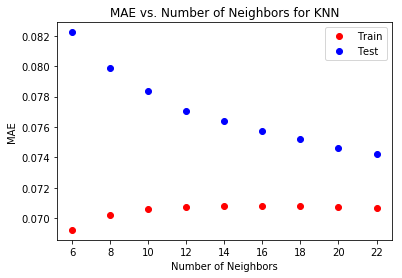

In [95]:
plt.plot(KNN_parameter_tuning_df['Num_Neighbors'], KNN_parameter_tuning_df['Train_MAE'], 'ro')
plt.plot(KNN_parameter_tuning_df['Num_Neighbors'], KNN_parameter_tuning_df['Test_MAE'], 'bo')
plt.title("MAE vs. Number of Neighbors for KNN")
plt.ylabel("MAE")
plt.xlabel("Number of Neighbors")
plt.legend(['Train', 'Test'])
plt.show()

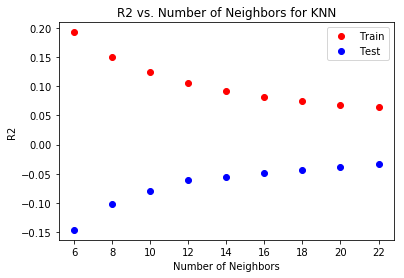

In [96]:
plt.plot(KNN_parameter_tuning_df['Num_Neighbors'], KNN_parameter_tuning_df['Train_R2_Score'], 'ro')
plt.plot(KNN_parameter_tuning_df['Num_Neighbors'], KNN_parameter_tuning_df['Test_R2_Score'], 'bo')
plt.title("R2 vs. Number of Neighbors for KNN")
plt.ylabel("R2")
plt.xlabel("Number of Neighbors")
plt.legend(['Train', 'Test'])
plt.show()

### K-Means Analysis 
We will use unsupervised learning to cluster the variables into groups. 


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans1 = KMeans(n_clusters = 3).fit(X_train)

In [ ]:
cluster_centers = pd.DataFrame(kmeans1.cluster_centers_, columns = train_df4.columns, index = [1,2,3])

In [ ]:
cluster_centers.head()

In [ ]:
cluster_centers.T[(cluster_centers.T[1] - cluster_centers.T[2]) > 0.02]

In [ ]:
cluster_centers.T[(cluster_centers.T[1] - cluster_centers.T[3]) > 0.02]

In [ ]:
# Cluster centers where the difference between the 2nd and 3rd is "high" 
cluster_centers.T[(cluster_centers.T[2] - cluster_centers.T[3]) > 0.02]

In [ ]:
print(kmeans1.labels_[kmeans1.labels_ == 0].size)
print(kmeans1.labels_[kmeans1.labels_ == 1].size)
print(kmeans1.labels_[kmeans1.labels_ == 2].size)

In [ ]:
kmeans1.labels_.shape

In [ ]:
print(y_train.loc[kmeans1.labels_ == 0].mean())
print(y_train.loc[kmeans1.labels_ == 1].mean())
print(y_train.loc[kmeans1.labels_ == 2].mean())

In [ ]:
print(y_train.loc[kmeans1.labels_ == 0].std())
print(y_train.loc[kmeans1.labels_ == 1].std())
print(y_train.loc[kmeans1.labels_ == 2].std())